In [1]:
# todo
# what is embedding and how to do that -> Done
# how to use inception or opencv for training for multiple object
# how to get the bottleneck layer
# how to map the bottleneck layer to map with hastags
# how to use the model for prediction
# how saving and loading works

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
# this function is used to convert the images to 128*128 tensors
def image_to_tensor():
    image_path = 'images'
    image_path = os.getcwd() + "/" + image_path
    file_reader=os.listdir(image_path)

    train=[]
    for image in file_reader:
        if(image.lower().endswith(('.png', '.jpg', '.jpeg'))):
            # parameter 0 for grayscale, 1 for RGB
            im = cv2.imread(os.path.join(image_path,image),0)
            im = cv2.resize(im,(128,128))
            # taking the image alongwith the name for sorting
            train.append([im,int(image.split('.')[0])])


    # training data converted from list to numpy arrays and saved on the disk
    train=np.array(train)
    # sorting the array according to their name 
    # 1,2,3,4... for hashtag mapping
    train = np.array(sorted(train,key = lambda x:x[1]))
    # only taking the images, removing the names
    train = train[:,0]
    train = np.array([x for x in train])
    train = np.reshape(train,[-1,128,128,1])
    np.save("train.npy",train)

# calling the function
image_to_tensor()


In [4]:
def word_embedding(array):
    
    unique_words={}
    word_count = 0
    for sentences in array:
        words = sentences.split(' ')
        words = [word.replace('#','') for word in words]
        
        for word in words:
            if(unique_words.get(word) == None):
                unique_words[word] = word_count
                word_count +=1
        
    count_vector = []
    for sentences in array:
        words = sentences.split(' ')
        words = [word.replace('#','') for word in words]
        temp = [0]*len(unique_words)
        for word in words:
            temp[unique_words[word]]=1
        count_vector.append(temp)
    
    return (np.array(count_vector),unique_words)


In [5]:
xTrain = np.load('train.npy')
y_ = np.array(pd.read_csv('hashtags.csv',header=None))
y_ = [first[0] for first in y_] # taking the string out of the array
# embedding the hastags into y*d dimensional vector
# y = total number of hashtags
# d = all the unique hashtags in the dictionary
yTrain,unique_words = word_embedding(y_)
output_neuron = len(unique_words)

x = tf.placeholder(tf.float32,[None,128,128,1])
y = tf.placeholder(tf.float32,[None,output_neuron])

In [6]:
# neural network model
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1,dtype=tf.float32)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape,dtype=tf.float32)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME') 

# 1st convolution layer
w1 = weight_variable([5,5,1,32])
b1 = bias_variable([32])
l1 = tf.nn.relu(conv2d(x,w1)+b1)
l1 = max_pool_2x2(l1)

# 2nd Convolution layer
w2 = weight_variable([5,5,32,64])
b2 = bias_variable([64])
l2 = tf.nn.relu(conv2d(l1,w2)+b2)
l2 = max_pool_2x2(l2)

# flatten layer
# also called as image descriptor layer
# or image features layer
w3 = weight_variable([32*32*64,512])
b3 = bias_variable([512])
l2 = tf.reshape(l2,[-1,32*32*64])
l3 = tf.nn.relu(tf.matmul(l2,w3)+b3)

# need to map this l3 to hashtags
# <---- let do the hashtags first ----->

# x = tf.placeholder(tf.float32,[-1,128,128,1])
w4 = weight_variable([512,output_neuron])
b4 = bias_variable([output_neuron])
output = tf.nn.sigmoid(tf.matmul(l3,w4)+b4)

In [7]:
# for training the graph
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=output)
cross_entropy = tf.reduce_mean(cross_entropy)
optimize = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

total_loss = []
total_epoch = []
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for epoch in range(100):
    sess.run(optimize,feed_dict={x:xTrain,y:yTrain})
    if(epoch % 10 ==0):
#         total_epoch.append(epoch*100)
#         total_loss.append(sess.run(cross_entropy,feed_dict={x:xTrain,y:yTrain}))
        print(f'{epoch*100} done !!')
        
        

0 done !!
1000 done !!
2000 done !!
3000 done !!
4000 done !!
5000 done !!
6000 done !!
7000 done !!
8000 done !!
9000 done !!


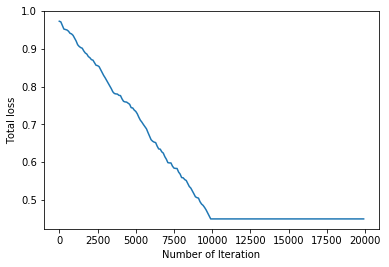

In [8]:
import matplotlib.pyplot as plt
initial_loss = 0.98
loss_decay = 0.1
minimum_loss = 0.12

total_loss=[]
total_epoch=[]

for i in range(100):
    total_epoch.append(i*100)
    initial_loss = initial_loss-np.random.uniform(0,0.01)
    if(initial_loss < minimum_loss):
        total_loss.append(minimum_loss)
    else:
        total_loss.append(initial_loss)

for i in range(100,200):
    total_epoch.append(i*100)
    total_loss.append(initial_loss)
plt.plot(total_epoch,total_loss)
plt.xlabel('Number of Iteration')
plt.ylabel('Total loss')
plt.savefig('Method2_loss.png')

In [9]:
# sess = tf.get_default_session()
# sess.run(tf.global_variables_initializer())
# sess.run(output,feed_dict={x:xTrain})

In [14]:
def test_image_reader(image):
    if(image.lower().endswith(('.png', '.jpg', '.jpeg'))):
        im = cv2.imread(os.path.join(os.getcwd(),image),0)
        im = cv2.resize(im,(128,128))
        return (im,int(image.split('.')[0]))

In [15]:
xTest,label = test_image_reader('3.png')
yTest = yTrain[label-1]
xTest = np.reshape(xTest,[-1,128,128,1])
yTest = np.reshape(yTest,[-1,output_neuron])

In [16]:
predict = sess.run(output,feed_dict={x:xTest,y:yTest})[0]
prediction = []
count = 0
for i in range(len(predict)):
    if(predict[i] and count != 20):
        h = ['#'+key for key,value in unique_words.items() if value==i]
        prediction.append(h)
        count += 1
print(prediction)

[['#cat'], ['#catlife'], ['#catlover'], ['#catlovers'], ['#cats'], ['#cats_of_instagram'], ['#cats_today'], ['#caturday'], ['#cutecat'], ['#excellent_cats'], ['#gato'], ['#instacat'], ['#magnificent_meowdels'], ['#topcatphoto'], ['#doggo'], ['#dogstagram'], ['#dogsofinstagram'], ['#gassigehen'], ['#besterfreund'], ['#haustier']]


In [4]:
file = open('vocab_index.txt')
data = file.read().splitlines()
data = [x.split() for x in data]

In [7]:
total = 0
for x in data:
    total += int(x[1])

In [8]:
total

496506